In [1]:
import sys
sys.path.append('..')
import h5py
import numpy as np
from numpy import einsum
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import configparser
from pathlib import Path
from scipy import interpolate
from scipy.stats import gaussian_kde

import tensorflow as tf
tf.keras.backend.set_floatx('float32')
from tensorflow.keras.losses import MeanSquaredError
mse = MeanSquaredError()

import MD_AE_tools.models.models as mdl_bias
import MD_AE_tools.models.models_no_bias as mdl_nobias
from project_specific_utils.helpers import GetAttr
import MD_AE_tools.mode_decomposition as md
import MD_AE_tools.ae_mode_selection as ranking
import MD_AE_tools.ae_mode_evaluation as mode_eval
from project_specific_utils.data_and_train import TrainNN_from_config, train_autoencder
from project_specific_utils import plot as myplot

config = configparser.ConfigParser()
config.read('./_system.ini')
results_dir = config['system_info']['alternate_location']

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[2], 'GPU')# use [] for cpu only, gpus[i] for the ith gpu
        # tf.config.set_logical_device_configuration(gpus[0], [tf.config.LogicalDeviceConfiguration(memory_limit=1024)]) 
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

# Load saved data

In [2]:
parent_folder = Path(results_dir,'experiment_standard_nonlinear')
# parent_folder = Path(results_dir,'experiment_linear_samedata')
!ls -v $parent_folder
folder_list = ! ls -v $parent_folder
# !tail -n 5 $parent_folder/*/log

2mode-regularised-1-764454  2mode-regularised-3-764456
2mode-regularised-2-764455


In [3]:
folder = folder_list[1]
folder_path = Path(parent_folder,folder)
filename = Path(folder_path,'training_param.ini')
mdl_config = TrainNN_from_config(filename)

filename = Path(folder_path,'results.h5')
with h5py.File(filename,'r') as hf:
    u_train = np.array(hf.get('u_train'))
    u_all = np.array(hf.get('u_all'))
    y_train = np.array(hf.get('y_train'))
    u_test = np.array(hf.get('u_test'))
    modes_train = np.array(hf.get('modes_train'))
    modes_test = np.array(hf.get('modes_test'))
    latent_train = np.array(hf.get('latent_train'))
    latent_test = np.array(hf.get('latent_test'))

    u_test_mean = np.array(hf.get('u_avg_test'))

print('MSE of traning is: ', mse(u_train,y_train).numpy())

MSE of traning is:  1.2085645


2022-12-26 10:37:58.203984: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-26 10:37:59.016758: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47217 MB memory:  -> device: 2, name: Quadro RTX 8000, pci bus id: 0000:a6:00.0, compute capability: 7.5


Calculating POD ...
Use classic POD, Nx <= Nt.


/home/ym917/Codes/MD-CNN-AE/MD_AE_tools/mode_decomposition.py:220: RuntimeWarning: invalid value encountered in sqrt
  normQ = (Q_POD.T @ Q_POD*self.w).real**0.5


POD done.
MSE reconstructed with 2 modes is:  1.4777343273162842
Calculating POD ...
User has selected classic POD
POD done.


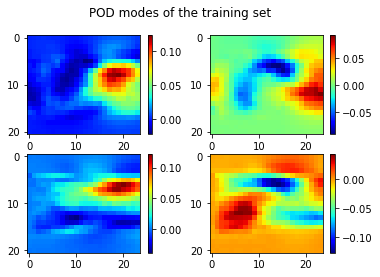

In [4]:
# data 
x = einsum('t y z u -> y z t u',np.squeeze(u_train))
X = np.vstack((x[:,:,:,0],x[:,:,:,1]))
pod = md.POD(X)
Q_POD,lam_data = pod.get_modes
Q_mean = pod.Q_mean
X_reconstructed = pod.reconstruct(2,shape=X.shape)
print('MSE reconstructed with 2 modes is: ', mse(X,X_reconstructed).numpy())

phi1 = Q_POD[:,0].reshape((42,24))
phi2 = Q_POD[:,1].reshape((42,24))
fig = plt.figure()
fig.suptitle('POD modes of the training set')
plt.subplot(221)
plt.imshow(phi1[:21,:],'jet')
plt.colorbar()
plt.subplot(223)
plt.imshow(phi1[21:,:],'jet')
plt.colorbar()
plt.subplot(222)
plt.imshow(phi2[:21,:],'jet')
plt.colorbar()
plt.subplot(224)
plt.imshow(phi2[21:,:],'jet')
plt.colorbar()

x_test = einsum('t y z u -> y z t u',np.squeeze(u_test))
X_test = np.vstack((x_test[:,:,:,0],x_test[:,:,:,1]))
pod_test = md.POD(X_test,method='classic')
A_test = pod_test.get_time_coefficient
Q_POD_test, lam_data_test = pod_test.get_modes

plt.show()

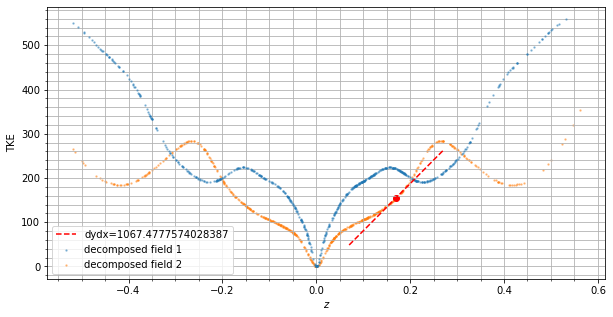

correlation coefficient 0.9282508989457271


In [5]:
ke = 0.5 * np.einsum('z t x y u -> z t', modes_test**2)

plt.figure(figsize=(10,5))
plt.scatter(latent_test[:,0], ke[0,:], alpha=0.4,label='decomposed field 1',s=2,zorder=2)
plt.scatter(latent_test[:,1], ke[1,:], alpha=0.4,label='decomposed field 2',s=2)
plt.xlabel('$z$')
plt.ylabel('TKE')
# plt.xlim([-0.01,0.15])
plt.minorticks_on()
plt.grid(which='both')
# plt.vlines(0.18,ymin=0.0001,ymax=500,linestyles='--',color='k')


### tangent
sort_idx = np.argsort(latent_test[:,1])
x_tan = latent_test[:,1][sort_idx]
y_tan = ke[1,:][sort_idx]
tck = interpolate.splrep(x_tan,y_tan)
x0 = 0.17
y0 = interpolate.splev(x0,tck)
dydx = interpolate.splev(x0,tck,der=1)
plt.scatter(x0,y0,c='r')
plot_tangent = np.linspace(x0-0.1,x0+0.1,50)
tngnt = lambda x: dydx*x + (y0-dydx*x0)
plt.plot(plot_tangent,tngnt(plot_tangent),'r--',label=f'dydx={dydx}')


plt.legend()
plt.show()

print('correlation coefficient', np.corrcoef(np.abs(latent_test[:,0]**2), ke[0,:])[0,1])

## From gradients

In [6]:
from MD_AE_tools.models import model_evaluation
from tensorflow.keras.optimizers import Adam

In [7]:
mdl = mdl_nobias.Autoencoder(Nx=mdl_config.Nx,Nu=mdl_config.Nu,
                            features_layers=mdl_config.features_layers,
                            latent_dim=mdl_config.latent_dim,
                            filter_window=mdl_config.filter_window,
                            act_fct=mdl_config.act_fct,
                            batch_norm=mdl_config.BATCH_NORM,
                            drop_rate=mdl_config.drop_rate,
                            lmb=mdl_config.lmb,
                            resize_meth=mdl_config.resize_meth)
mdl.compile(optimizer=Adam(learning_rate=mdl_config.learning_rate),loss='mse')
mdl.evaluate(np.squeeze(u_train),np.squeeze(u_train))

# ==============================================
filename = Path(folder_path,'md_ae_model.h5')
mdl.load_weights(filename)
mdl.evaluate(np.squeeze(u_train),np.squeeze(u_train))

# ===============================================
decoder = mdl.decoder

2022-12-26 10:38:04.267422: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204


51/51 [==============================] - 0s 7ms/step - loss: 1.2227


In [8]:
gridx,gridy = (51,201)
z1 = np.linspace(-0.1,0.1,gridx).astype('float32')
z2 = np.linspace(-0.2,0.2,gridy).astype('float32')
print(np.argwhere(np.abs(z1-0)<1.19209e-07))
zx,zy = np.meshgrid(z1,z2)

[[25]]


In [9]:
tf.stack([zx[:3,0],zy[:3,0]],axis=1)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-0.1  , -0.2  ],
       [-0.1  , -0.198],
       [-0.1  , -0.196]], dtype=float32)>

In [10]:
gradients = model_evaluation.get_gradient_m_z(tf.stack([zx[:3,0],zy[:3,0]],axis=1),decoder)

In [11]:
gradients.shape

TensorShape([3, 21, 24, 2, 2])

In [12]:
### compute derivatives in batches
batch_size = 60
dy_dz = []

# hold z1 constant, change z2
for i in range(len(z1)):
    dy_dz_i = []
    t = 0
    # for j in range(len(z2)):
    while (t+batch_size) < len(z2):

        # print(f'in this batch t={t} to {t+batch_size}')

        gradients = model_evaluation.get_gradient_m_z(
            tf.stack([zx[t:t+batch_size,i],zy[t:t+batch_size,0]],axis=1),
            decoder
        ) # [batch,....,z]

        dy_dz_i.append(gradients)

        t = t + batch_size
    
    # print(f'in this batch t={t} to {len(z2)}')
    gradients = model_evaluation.get_gradient_m_z(tf.stack([zx[t:,0],zy[t:,0]],axis=1),decoder) 

    dy_dz_i.append(gradients)

    dy_dz.append(np.vstack(dy_dz_i))

dy_dz = np.array(dy_dz) # (no.of z1, z2, ny, nz, nu, latent_dim)

In [13]:
dy_dz.shape

(51, 201, 21, 24, 2, 2)

In [14]:
dy_dz_vector = []
dy_dz_temp = einsum('k t y z u -> k y z t u', dy_dz[...,1]) # only dy/dz2

for i in range(len(z1)):
    dy_dz_reshape = np.vstack((dy_dz_temp[i,:,:,:,0], dy_dz_temp[i,:,:,:,1]))
    dy_dz_reshape = np.reshape(dy_dz_reshape,(-1, len(z2)))
    dy_dz_vector.append(dy_dz_reshape)

dy_dz_vector = np.array(dy_dz_vector)
dy_dz_vector.shape

(51, 1008, 201)

In [15]:
dB_dz = []
for i in range(len(z1)):
    dB_dz.append(Q_POD.T @ dy_dz_vector[i,...])
dB_dz = np.array(dB_dz)
dB_dz.shape

(51, 1008, 201)

In [18]:
bound = model_evaluation.one_step_integrate(z1,dB_dz[25,0,:],0,0,z2[1]-z2[0])

In [19]:
B = [] # [z1,modes,z2]
for i in range(len(z1)):
    B_z1 = [] # B at constant z1
    for m in range(1):
        ##### cannot give (0,0)
        B_z1.append(model_evaluation.one_step_integrate(z2,dB_dz[i,m,:],0,bound[i],z2[1]-z2[0]))
    B.append(B_z1)
B = np.array(B)
B.shape

(51, 1, 201)

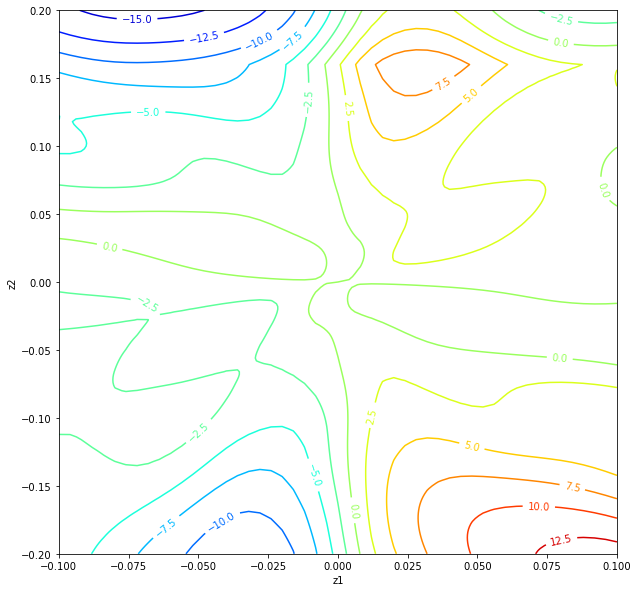

In [24]:
fig = plt.figure(figsize=(10,10))
cs = plt.contour(zx,zy,B[:,0,:].T,12,cmap='jet')
plt.xlabel('z1')
plt.ylabel('z2')
plt.clabel(cs)
plt.show()

In [95]:
zx.shape

(201, 51)